In [2]:
import h5py
import numpy as np
import pandas as pd
import cv2 as cv
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
path = './'

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adadelta 
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
def NYU_extract ():
    with np.load(path+'nyu_compressed_1.npz') as nyu_raw:
        data = dict()
        data['images'] = nyu_raw['images']
        data['depths'] = nyu_raw['depths']
        return data

In [4]:
data = NYU_extract()

In [5]:
data['depths'].shape

(1449, 480, 640, 1)

In [6]:
m = data['depths']*10

In [7]:
def sil(y_true,y_pred):
    y_true_f  = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    n = K.int_shape(y_pred)[1]*K.int_shape(y_pred)[2]
    alpha = (1./n)*(K.sum(K.log(y_pred_f)-K.log(y_true_f)))
    return (1./n) * K.sum(((K.log(y_true_f)-(K.log(y_pred_f)))+(alpha))**2)

In [ ]:
train_img, test_img, train_dep, test_dep = train_test_split(data['images'], m, test_size = 0.2, random_state = 1)
train_img, val_img, train_dep, val_dep = train_test_split(train_img, train_dep, test_size = 0.2, random_state = 1)

In [ ]:
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

In [ ]:
# this is our input placeholder
input_img = Input(shape=(480, 640, 3))

In [10]:
layer_1 = Conv2D(128, (20, 20),strides=4, activation='relu', padding='same')(input_img)
layer_2 = MaxPooling2D((2, 2), padding='same')(layer_1)
layer_3 = Conv2D(512, (10, 10), activation='relu', padding='same')(layer_2)
layer_4 = MaxPooling2D((2, 2), padding='same')(layer_3)
layer_5 = Conv2D(400, (5, 5), activation='relu', padding='same')(layer_4)
layer_6 = Conv2D(400, (5, 5), activation='relu', padding='same')(layer_5)
layer_7 = Conv2D(256, (5, 5), activation='relu', padding='same')(layer_6)
layer_8 = Dense(512, kernel_initializer='he_uniform', activation='relu')(layer_7)
layer_9 = Dense(8192, kernel_initializer='he_uniform', activation='relu')(layer_8)
layer_10 = Dense(1, kernel_initializer='he_uniform', activation='linear')(layer_9)
coarse_output = UpSampling2D((16, 16))(layer_10)

In [11]:
coarse = Model(input_img, coarse_output)

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred*10 - y_true*10), axis=-1)) 

In [ ]:
def abs_rel_err(y_true,y_pred):
        return K.mean(K.abs(y_true*10-y_pred*10)/(y_pred*10), axis=-1)

In [ ]:
def rmse_log(y_true,y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_true)-K.log(y_pred)), axis = -1))

In [ ]:
def scaled(y_true,y_pred):
    y_true_f  = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    n = K.int_shape(y_pred)[1]*K.int_shape(y_pred)[2]
    alpha = (1./n)*(K.sum(K.log(y_pred_f)-K.log(y_true_f)))
    return (1./n) * K.sum(((K.log(y_true_f)-(K.log(y_pred_f)))+(alpha))**2)

In [ ]:
ada = Adadelta(lr=0.0025, rho=0.95, epsilon=None, decay=0.0)

In [17]:
coarse.compile(optimizer=ada, loss='mean_squared_error', metrics =[root_mean_squared_error,abs_rel_err,rmse_log])
coarse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 160, 128)     153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 80, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 512)       6554112   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 40, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 40, 400)       5120400   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 40, 400)       4000400   
__________

In [18]:
checkpointer = ModelCheckpoint(filepath="coarse_weights_10.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = coarse.fit(train_img, train_dep,
                epochs=400,
                batch_size=32,
                shuffle=True,
                validation_data = (val_img, val_dep),
                callbacks=[TensorBoard(log_dir='/tmp/multi'),checkpointer])

Train on 927 samples, validate on 232 samples
Epoch 1/400
927/927 [==============================] - 37s 40ms/step - loss: 0.0525 - root_mean_squared_error: 1.8383 - abs_rel_err: 1.6824 - rmse_log: inf - val_loss: 0.0300 - val_root_mean_squared_error: 1.3339 - val_abs_rel_err: 1.1710 - val_rmse_log: 0.6331

Epoch 00001: val_loss improved from inf to 0.03004, saving model to coarse_weights_10.hdf5
Epoch 2/400
927/927 [==============================] - 27s 29ms/step - loss: 0.0277 - root_mean_squared_error: 1.2889 - abs_rel_err: 0.9269 - rmse_log: 0.5808 - val_loss: 0.0268 - val_root_mean_squared_error: 1.2558 - val_abs_rel_err: 0.8571 - val_rmse_log: 0.5520

Epoch 00002: val_loss improved from 0.03004 to 0.02682, saving model to coarse_weights_10.hdf5
Epoch 3/400
927/927 [==============================] - 26s 28ms/step - loss: 0.0253 - root_mean_squared_error: 1.2258 - abs_rel_err: 0.7471 - rmse_log: 0.5265 - val_loss: 0.0249 - val_root_mean_squared_error: 1.2027 - val_abs_rel_err: 0.73


Epoch 00023: val_loss improved from 0.01723 to 0.01722, saving model to coarse_weights_10.hdf5
Epoch 24/400
927/927 [==============================] - 27s 29ms/step - loss: 0.0172 - root_mean_squared_error: 0.9801 - abs_rel_err: 0.3650 - rmse_log: 0.3660 - val_loss: 0.0175 - val_root_mean_squared_error: 0.9660 - val_abs_rel_err: 0.3900 - val_rmse_log: 0.3593

Epoch 00024: val_loss did not improve from 0.01722
Epoch 25/400
927/927 [==============================] - 27s 29ms/step - loss: 0.0171 - root_mean_squared_error: 0.9744 - abs_rel_err: 0.3654 - rmse_log: 0.3641 - val_loss: 0.0169 - val_root_mean_squared_error: 0.9697 - val_abs_rel_err: 0.3664 - val_rmse_log: 0.3585

Epoch 00025: val_loss improved from 0.01722 to 0.01694, saving model to coarse_weights_10.hdf5
Epoch 26/400
864/927 [==========================>...] - ETA: 1s - loss: 0.0169 - root_mean_squared_error: 0.9709 - abs_rel_err: 0.3617 - rmse_log: 0.3628

In [ ]:
layer_1 = Conv2D(128, (20, 20),strides=4, activation='relu', padding='same')(input_img)
layer_2 = MaxPooling2D((2, 2), padding='same')(layer_1)
layer_3 = Conv2D(512, (10, 10), activation='relu', padding='same')(layer_2)
layer_4 = MaxPooling2D((2, 2), padding='same')(layer_3)
layer_5 = Conv2D(400, (5, 5), activation='relu', padding='same')(layer_4)
layer_6 = Conv2D(400, (5, 5), activation='relu', padding='same')(layer_5)
layer_7 = Conv2D(256, (5, 5), activation='relu', padding='same')(layer_6)
layer_8 = Dense(512, kernel_initializer='he_uniform', activation='relu')(layer_7)
layer_9 = Dense(8192, kernel_initializer='he_uniform', activation='relu')(layer_8)
layer_10 = Dense(1, kernel_initializer='he_uniform', activation='linear')(layer_9)
coarse_output_trained = UpSampling2D((16, 16))(layer_10)
coarse_trained = Model(input_img, coarse_output_trained)
coarse_trained.trainable = False
coarse_trained.compile(optimizer=ada, loss='mean_squared_error', metrics =[root_mean_squared_error,abs_rel_err,rmse_log])
coarse_trained.load_weights("coarse_weights_10.hdf5")

In [ ]:
coarse_trained.summary()

In [17]:
layer_1 = Conv2D(63, (9, 9), activation='relu', padding='same',name="1")(input_img)
concatenate_layer = concatenate([coarse_output_trained, layer_1])
layer_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(concatenate_layer)
layer_3 = Conv2D(64, (5, 5), activation='linear', padding='same')(layer_2)
fine_output_1 = Dense(1, kernel_initializer='he_uniform', activation='relu')(layer_3)
#fine_output_1 = UpSampling2D((16, 16))(layer_4)

In [18]:
fine1 = Model(input_img, fine_output_1)
fine1.compile(optimizer=ada, loss='mean_squared_error', metrics =[root_mean_squared_error,abs_rel_err,rmse_log])
fine1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 160, 128 153728      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 60, 80, 128)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 60, 80, 512)  6554112     max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [ ]:
checkpointer = ModelCheckpoint(filepath="fine_weights_6.hdf5", verbose=1, save_best_only=True)

In [21]:
history = fine1.fit(train_img, train_dep,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data = (val_img, val_dep),
                callbacks=[TensorBoard(log_dir='/tmp/multi'),checkpointer])

Train on 927 samples, validate on 232 samples
Epoch 1/100
927/927 [==============================] - 102s 110ms/step - loss: 0.0974 - root_mean_squared_error: 2.7985 - abs_rel_err: inf - rmse_log: inf - val_loss: 0.0984 - val_root_mean_squared_error: 2.8163 - val_abs_rel_err: inf - val_rmse_log: inf

Epoch 00001: val_loss improved from inf to 0.09845, saving model to fine_weights_5.hdf5
Epoch 2/100
927/927 [==============================] - 95s 102ms/step - loss: 0.0973 - root_mean_squared_error: 2.7973 - abs_rel_err: inf - rmse_log: inf - val_loss: 0.0983 - val_root_mean_squared_error: 2.8134 - val_abs_rel_err: inf - val_rmse_log: inf

Epoch 00002: val_loss improved from 0.09845 to 0.09830, saving model to fine_weights_5.hdf5
Epoch 3/100
927/927 [==============================] - 95s 102ms/step - loss: 0.0555 - root_mean_squared_error: 1.8815 - abs_rel_err: inf - rmse_log: inf - val_loss: 0.0274 - val_root_mean_squared_error: 1.2468 - val_abs_rel_err: inf - val_rmse_log: inf

Epoch 00

KeyboardInterrupt: 

In [58]:
# layer_1 = Conv2D(63, (9, 9), activation='relu', padding='same',name="1")(input_img)
# concatenate_layer = concatenate([coarse_output_trained, layer_1])
# layer_2 = Conv2D(64, (5, 5), activation='relu', padding='same')(concatenate_layer)
# layer_3 = Conv2D(64, (5, 5), activation='linear', padding='same')(layer_2)
# fine_output_trained = Dense(1, kernel_initializer='he_uniform', activation='relu')(layer_3)
# fine_trained = Model(input_img, fine_output_trained)
# fine_trained.trainable = False
# fine_trained.compile(optimizer=ada, loss='mean_squared_error', metrics =[root_mean_squared_error,abs_rel_err,rmse_log])
# fine_trained.load_weights("fine_weights_5.hdf5")

In [ ]:
result = coarse_trained.predict(train_img)

In [ ]:
fine1.evaluate(train_img, train_dep)

In [ ]:
result[20].shape

In [ ]:
new = np.reshape(result[50],(480,640))
plt.imshow(new)

In [ ]:
dep = np.reshape(train_dep[50],(480,640))
plt.imshow(dep)

In [ ]:
plt.imshow(train_img[90])

In [134]:
import cv2 as cv

real1=cv.imread('real1.jpg',1)
real2=cv.imread('real2.jpg',1)
real3=cv.imread('real3.jpg',1)
real4=cv.imread('real4.jpg',1)

In [135]:
real1.shape

(1310, 1746, 3)

In [136]:
real1 = cv.cvtColor(real1, cv.COLOR_BGR2RGB)
real2 = cv.cvtColor(real2, cv.COLOR_BGR2RGB)
real3 = cv.cvtColor(real3, cv.COLOR_BGR2RGB)
real4 = cv.cvtColor(real4, cv.COLOR_BGR2RGB)

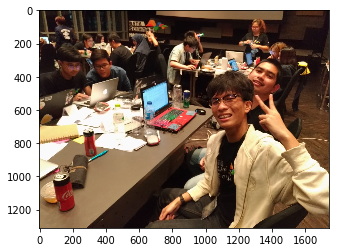

In [113]:
plt.imshow(real1)

In [137]:
import cv2 as cv
real1=cv.resize(real1,(640,480))
real2=cv.resize(real2,(640,480))
real3=cv.resize(real3,(640,480))
real4=cv.resize(real4,(640,480))
n = []
n.append(real1)
n.append(real2)
n.append(real3)
n.append(real4)

In [138]:
n = np.array(n)

In [139]:
rest = fine_trained.predict(n)

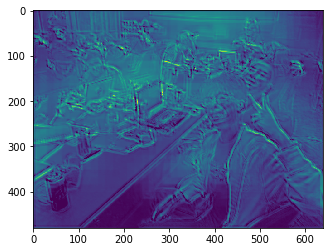

In [117]:
new_r1 = np.reshape(rest[0],(480,640))
plt.imshow(new_r1)

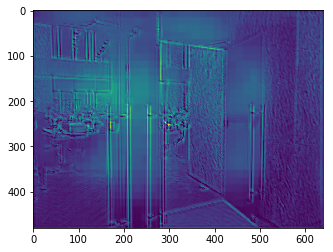

In [118]:
new_r1 = np.reshape(rest[1],(480,640))
plt.imshow(new_r1)

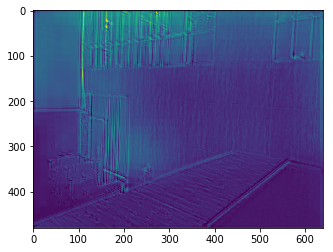

In [129]:
new_r2 = np.reshape(rest[2],(480,640))
plt.imshow(new_r2)

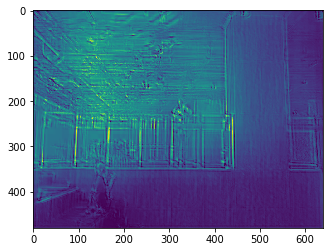

In [140]:
new_r3 = np.reshape(rest[3],(480,640))
plt.imshow(new_r3)

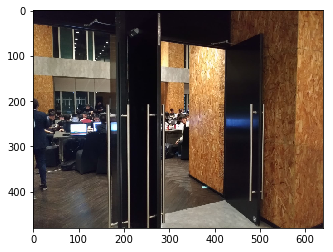

In [120]:
plt.imshow(n[1])